In [1]:
import os
from pathlib import Path
import torch
import yaml
from yaml.loader import SafeLoader

In [2]:
results_dir = r"..\results"
project_dir = "hypertune"
checkpoint_dir = "models"
checkpoint_name = "checkpoint_epoch"
model_id = "GB_Adv"

In [3]:
# find folders for each run
def get_dir(results_dir, project_dir, checkpoint_dir, checkpoint_name, model_id):
    results_dir = Path(results_dir)
    project_dir = Path(project_dir)
    checkpoint_dir = Path(checkpoint_dir)

    exps = []
    for root, dirs, files in os.walk(results_dir / project_dir):
        # for file in files:
            # if file.endswith(".txt"):
                # print(os.path.join(root, file))
        for dir in dirs:
            if dir.startswith(model_id):
                _dirs = Path(os.path.join(root, dir))

                # Open the file and load the file
                with open(_dirs / 'opt.yaml') as f:
                    _opt = yaml.load(f, Loader=SafeLoader)
                
                _checkpoints_dirs = []
                for root2, dirs2, files2 in os.walk(_dirs / checkpoint_dir):
                    for file2 in files2:
                        if file2.startswith(checkpoint_name):
                            _dirs2 = os.path.join(root2, file2)
                            _checkpoints_dirs.append(_dirs2)
                exps.append(
                    {
                        "opt":_opt,
                        "dir":_checkpoints_dirs,
                    }
                )
    return exps

In [6]:
INLP_exps = get_dir(
    results_dir= r"G:\Experimental_results",
    project_dir=r"INLP/Moji", 
    checkpoint_dir= "models",
    checkpoint_name= "INLP_checkpoint_iteration",
    model_id="INLP"
    )

In [8]:
len(INLP_exps)

8

In [29]:
exps = get_dir(
    results_dir=results_dir, 
    project_dir="dev", 
    checkpoint_dir=checkpoint_dir, 
    checkpoint_name=checkpoint_name, 
    model_id=model_id)

In [30]:
len(exps)

4

In [31]:
exps[0]["opt"]

{'BT': None,
 'BTObj': None,
 'activation_function': 'Tanh',
 'adv_BT': 'Reweighting',
 'adv_BTObj': 'joint',
 'adv_activation_function': 'ReLu',
 'adv_batch_norm': False,
 'adv_batch_size': 1024,
 'adv_checkpoint_interval': 1,
 'adv_debiasing': True,
 'adv_decoupling': False,
 'adv_diverse_lambda': 0.0,
 'adv_dropout': 0,
 'adv_epochs': 100,
 'adv_epochs_since_improvement': 5,
 'adv_gated': True,
 'adv_gated_mapping': None,
 'adv_hidden_size': 300,
 'adv_lambda': 0.5,
 'adv_level': 'last_hidden',
 'adv_lr': 0.001,
 'adv_n_hidden': 2,
 'adv_num_classes': 2,
 'adv_num_subDiscriminator': 1,
 'adv_test_batch_size': 1024,
 'adv_uniform_label': False,
 'adv_update_frequency': 'Batch',
 'base_seed': 1,
 'batch_norm': False,
 'batch_size': 1024,
 'checkpoint_interval': 1,
 'data_dir': None,
 'dataset': 'Moji',
 'device_id': 0,
 'dropout': 0,
 'emb_size': 2304,
 'encoder_architecture': 'Fixed',
 'epochs': 100,
 'epochs_since_improvement': 10,
 'exp_id': 'GB_Adv_lmbda_0.5',
 'full_label': True,

In [32]:
exps[0]["dir"]

['..\\results\\dev\\Moji\\GB_Adv_lmbda_0.5\\models\\checkpoint_epoch0.pth.tar',
 '..\\results\\dev\\Moji\\GB_Adv_lmbda_0.5\\models\\checkpoint_epoch1.pth.tar',
 '..\\results\\dev\\Moji\\GB_Adv_lmbda_0.5\\models\\checkpoint_epoch10.pth.tar',
 '..\\results\\dev\\Moji\\GB_Adv_lmbda_0.5\\models\\checkpoint_epoch2.pth.tar',
 '..\\results\\dev\\Moji\\GB_Adv_lmbda_0.5\\models\\checkpoint_epoch3.pth.tar',
 '..\\results\\dev\\Moji\\GB_Adv_lmbda_0.5\\models\\checkpoint_epoch4.pth.tar',
 '..\\results\\dev\\Moji\\GB_Adv_lmbda_0.5\\models\\checkpoint_epoch5.pth.tar',
 '..\\results\\dev\\Moji\\GB_Adv_lmbda_0.5\\models\\checkpoint_epoch6.pth.tar',
 '..\\results\\dev\\Moji\\GB_Adv_lmbda_0.5\\models\\checkpoint_epoch7.pth.tar',
 '..\\results\\dev\\Moji\\GB_Adv_lmbda_0.5\\models\\checkpoint_epoch8.pth.tar',
 '..\\results\\dev\\Moji\\GB_Adv_lmbda_0.5\\models\\checkpoint_epoch9.pth.tar']

In [32]:
test_file = torch.load(exps[0]["dir"][0])

In [33]:
test_file.keys()

dict_keys(['epoch', 'epochs_since_improvement', 'loss', 'dev_predictions', 'test_predictions', 'dev_evaluations', 'test_evaluations'])

In [34]:
test_file["epoch"]

0

In [35]:
test_file["dev_evaluations"]

{'rms_TPR': 0.3116297883707525,
 'accuracy': 0.732625,
 'macro_fscore': 0.7326237926293135,
 'micro_fscore': 0.732625}

In [14]:
import numpy as np

def power_mean(series, p):
    if p>50:
        return max(series)
    elif p<50:
        return min(series)
    else:
        total = np.mean(np.power(series, p))
        return np.power(total, 1 / p)

def l2norm(matrix_1, matrix_2):
    """calculate Euclidean distance

    Args:
        matrix_1 (n*d np array): n is the number of instances, d is num of metric
        matrix_2 (n*d np array): same as matrix_1

    Returns:
        _type_: _description_
    """
    return np.power(np.sum(np.power(matrix_1-matrix_2, 2), axis=1), 0.5)

In [15]:
def DTO(fairness_metric, performacne_metric, utopia_fairness = None, utopia_performance = None):
    """calculate DTO for each condidate model

    Args:
        fairness_metric (List): fairness evaluation results (1-GAP)
        performacne_metric (List): performance evaluation results
    """
    
    fairness_metric, performacne_metric = np.array(fairness_metric), np.array(performacne_metric)
    # Best metric
    if (utopia_performance is None):
        utopia_performance = np.max(performacne_metric)
    if (utopia_fairness is None):
        utopia_fairness = np.max(fairness_metric)

    # Normalize
    performacne_metric = performacne_metric/utopia_performance
    fairness_metric = fairness_metric/utopia_fairness

    # Reshape and concatnate
    performacne_metric = performacne_metric.reshape(-1,1)
    fairness_metric = fairness_metric.reshape(-1,1)
    normalized_metric = np.concatenate([performacne_metric, fairness_metric], axis=1)

    # Calculate Euclidean distance
    return l2norm(normalized_metric, np.ones_like(normalized_metric))

In [35]:
{'rms_TPR': 0.3116297883707525,
 'accuracy': 0.732625,
 'macro_fscore': 0.7326237926293135,
 'micro_fscore': 0.732625}

{'rms_TPR': 0.3116297883707525,
 'accuracy': 0.732625,
 'macro_fscore': 0.7326237926293135,
 'micro_fscore': 0.732625}

In [9]:
import pandas as pd

In [10]:
from joblib import Parallel, delayed

In [12]:
# exp = exps[0]
GAP_metric = "rms_TPR"
Performance_metric = "accuracy"

def get_model_scores(exp, GAP_metric, Performance_metric,n_jobs=2):
    """given the log path for a exp, read log and return the dev&test performacne, fairness, and DTO

    Args:
        exp (_type_): get_dir output, includeing the options and path to checkpoints
        GAP_metric (_type_): the target GAP metric name
        Performance_metric (_type_): the target performance metric name, e.g., F1, Acc.

    Returns:
        pd.DataFrame: a pandas df including dev and test scores for each epoch
    """

    epoch_id = []
    epoch_scores_dev = {"performance":[],"fairness":[]}
    epoch_scores_test = {"performance":[],"fairness":[]}

    _epoch_results = Parallel(n_jobs=n_jobs)(delayed(torch.load)(i) for i in exp["dir"])

    # for epoch_result_dir in exp["dir"]:
    #     epoch_result = torch.load(epoch_result_dir)
    for epoch_result in _epoch_results:

        # Track the epoch id
        epoch_id.append(epoch_result["epoch"])

        # Get evaluation scores
        epoch_scores_dev["fairness"].append(1-epoch_result["dev_evaluations"][GAP_metric])
        epoch_scores_test["fairness"].append(1-epoch_result["test_evaluations"][GAP_metric])

        epoch_scores_dev["performance"].append(epoch_result["dev_evaluations"][Performance_metric])
        epoch_scores_test["performance"].append(epoch_result["test_evaluations"][Performance_metric])

    # Calculate the DTO for dev and test 
    dev_DTO = DTO(fairness_metric=epoch_scores_dev["fairness"], performacne_metric=epoch_scores_dev["performance"])
    test_DTO = DTO(fairness_metric=epoch_scores_test["fairness"], performacne_metric=epoch_scores_test["performance"])

    epoch_scores = pd.DataFrame(
        {
            "selected_epoch":epoch_id,
            "dev_{}".format(GAP_metric):epoch_scores_dev["fairness"],
            "dev_{}".format(Performance_metric):epoch_scores_dev["performance"],
            "dev_DTO":dev_DTO,
            "test_{}".format(GAP_metric):epoch_scores_test["fairness"],
            "test_{}".format(Performance_metric):epoch_scores_test["performance"],
            "test_DTO":test_DTO,
        }
    )

    return epoch_scores

In [ ]:
def load_INLP_results(
    results_dir,
    project_dir,
    checkpoint_dir,
    checkpoint_name,
    model_id,):
    INLP_exps = get_dir(
        results_dir=results_dir,
        project_dir=project_dir,
        checkpoint_dir=checkpoint_dir,
        checkpoint_name=checkpoint_name,
        model_id=model_id,
        )

In [20]:
get_model_scores(INLP_exps[0], GAP_metric, Performance_metric,n_jobs=2)

,dev_rms_TPR,dev_accuracy,dev_DTO,test_rms_TPR,test_accuracy,test_DTO
selected_epoch,,,,,,
0,0.607997,0.722875,0.391326,0.589516,0.720555,0.392763
1,0.608123,0.722875,0.391200,0.593346,0.721680,0.388799
10,0.608300,0.721750,0.391033,0.589869,0.720555,0.392400
100,0.998882,0.509500,0.296392,0.970752,0.520130,0.282264
101,0.998882,0.509500,0.296392,0.970752,0.520130,0.282264
...,...,...,...,...,...,...
95,0.998882,0.509500,0.296392,0.970752,0.520130,0.282264
96,0.998882,0.509500,0.296392,0.970752,0.520130,0.282264
97,0.998882,0.509500,0.296392,0.970752,0.520130,0.282264


In [39]:
from joblib import Parallel, delayed
from src.readlogs import retrive_exp_results

In [40]:
# retrive_exp_results(exp,GAP_metric_name, Performance_metric_name,selection_criterion,index_column_names)

In [21]:
from tqdm import tqdm 

def model_selection(
    results_dir,
    project_dir,
    checkpoint_dir,
    checkpoint_name,
    model_id,
    GAP_metric_name,
    Performance_metric_name,
    selection_criterion,
    index_column_names = ['adv_lambda', 'adv_num_subDiscriminator', 'adv_diverse_lambda'],
    n_jobs=2,
    return_all=False,
    ):
    """perform model selection over different runs wrt different hyperparameters

    Args:
        results_dir (_type_): _description_
        project_dir (_type_): _description_
        checkpoint_dir (_type_): _description_
        checkpoint_name (_type_): _description_
        model_id (_type_): _description_
        GAP_metric_name (_type_): _description_
        Performance_metric_name (_type_): _description_
        selection_criterion (_type_): _description_

    Returns:
        _type_: _description_
    """
    exps = get_dir(
        results_dir=results_dir, 
        project_dir=project_dir, 
        checkpoint_dir=checkpoint_dir, 
        checkpoint_name=checkpoint_name, 
        model_id=model_id)

    exp_results = []
    if n_jobs == 0:
        for exp in tqdm(exps):
            # Get scores
            epoch_scores = get_model_scores(exp=exp, GAP_metric=GAP_metric_name, Performance_metric=Performance_metric_name)
            if not return_all:
                selected_epoch_id = np.argmin(epoch_scores["dev_{}".format(selection_criterion)])
                selected_epoch_scores = epoch_scores.iloc[selected_epoch_id:selected_epoch_id+1]
            else:
                pass

            _exp_opt = exp["opt"]

            # Get hyperparameters for this epoch
            _exp_results = {}
            for hyperparam_key in index_column_names:
                _exp_results[hyperparam_key] = _exp_opt[hyperparam_key]

            # Merge opt with scores
            for key in selected_epoch_scores.keys():
                _exp_results[key] = selected_epoch_scores[key]

            exp_results.append(_exp_results)
    else:
        exp_results = Parallel(n_jobs=n_jobs, verbose=5)(delayed(retrive_exp_results) 
                                            (exp,GAP_metric_name, Performance_metric_name,selection_criterion,index_column_names)
                                            for exp in exps)
    return pd.DataFrame(exp_results)

In [41]:
def retrive_exp_results(exp,GAP_metric_name, Performance_metric_name,selection_criterion,index_column_names, return_all=False):
    # Get scores
    epoch_scores = get_model_scores(exp=exp, GAP_metric=GAP_metric_name, Performance_metric=Performance_metric_name)
    if not return_all:
        if selection_criterion == "DTO":
            selected_epoch_id = np.argmin(epoch_scores["dev_{}".format(selection_criterion)])
        else:
            selected_epoch_id = np.argmax(epoch_scores["dev_{}".format(selection_criterion)])
        selected_epoch_scores = epoch_scores.iloc[[selected_epoch_id]].copy()
        
        _exp_results = selected_epoch_scores
    else:
        _exp_results = epoch_scores
    
    _exp_opt = exp["opt"]
    # Get hyperparameters for this epoch
    for hyperparam_key in index_column_names:
        _exp_results[hyperparam_key] = [_exp_opt[hyperparam_key]]*len(_exp_results)

    return _exp_results

In [44]:
INLP_0 = retrive_exp_results(
    exp = INLP_exps[0],
    GAP_metric_name = "rms_TPR",
    Performance_metric_name = "accuracy",
    selection_criterion = "DTO",
    index_column_names = ['INLP_by_class', 'INLP_discriminator_reweighting', 'INLP_min_acc'],
    return_all=True
)

INLP_1 = retrive_exp_results(
    exp = INLP_exps[1],
    GAP_metric_name = "rms_TPR",
    Performance_metric_name = "accuracy",
    selection_criterion = "DTO",
    index_column_names = ['INLP_by_class', 'INLP_discriminator_reweighting', 'INLP_min_acc'],
    return_all=True
)

In [50]:
pd.concat([INLP_1,INLP_0]).set_index(["selected_epoch"])

,dev_rms_TPR,dev_accuracy,dev_DTO,test_rms_TPR,test_accuracy,test_DTO,INLP_by_class,INLP_discriminator_reweighting,INLP_min_acc
selected_epoch,,,,,,,,,
0,0.607144,0.721875,0.383624,0.588779,0.721305,0.398428,False,balanced,0.0
1,0.606842,0.722250,0.383908,0.591998,0.722181,0.395070,False,balanced,0.0
10,0.608355,0.724125,0.382270,0.592374,0.721680,0.394726,False,balanced,0.0
100,0.953902,0.513000,0.303154,0.958316,0.502001,0.321361,False,balanced,0.0
101,0.953902,0.513000,0.303154,0.958316,0.502001,0.321361,False,balanced,0.0
...,...,...,...,...,...,...,...,...,...
95,0.998882,0.509500,0.296392,0.970752,0.520130,0.282264,False,balanced,0.5
96,0.998882,0.509500,0.296392,0.970752,0.520130,0.282264,False,balanced,0.5
97,0.998882,0.509500,0.296392,0.970752,0.520130,0.282264,False,balanced,0.5


In [28]:
model_selection(
    results_dir= r"G:\Experimental_results",
    project_dir=r"INLP/Moji", 
    checkpoint_dir= "models",
    checkpoint_name= "INLP_checkpoint_iteration",
    model_id="INLP",
    GAP_metric_name = "rms_TPR",
    Performance_metric_name = "accuracy",
    selection_criterion = "DTO",
    index_column_names = ['INLP_by_class', 'INLP_discriminator_reweighting', 'INLP_min_acc'],
    n_jobs=0,
    return_all=False,
    )

100%|██████████| 8/8 [00:00<00:00,  8.58it/s]


,INLP_by_class,INLP_discriminator_reweighting,INLP_min_acc,selected_epoch,dev_rms_TPR,dev_accuracy,dev_DTO,test_rms_TPR,test_accuracy,test_DTO
0,False,balanced,0.5,28.0,0.837435,0.596750,0.238883,0.799365,0.595899,0.250501
1,False,balanced,0.0,60.0,0.863653,0.575875,0.248370,0.853453,0.589647,0.238721
2,False,None,0.5,26.0,0.785683,0.616625,0.231856,0.757999,0.622781,0.249229
3,False,None,0.0,25.0,0.788231,0.614125,0.257964,0.766931,0.616154,0.270139
4,True,balanced,0.5,117.0,0.870945,0.705625,0.110043,0.864381,0.711553,0.117569
5,True,balanced,0.0,91.0,0.860852,0.726250,0.115686,0.853738,0.734559,0.141844
6,True,None,0.5,47.0,0.786388,0.731750,0.005437,0.774648,0.738310,0.005725
7,True,None,0.0,98.0,0.874601,0.706500,0.118731,0.853641,0.709177,0.144276


In [111]:
Moji_GatedAdv_df = model_selection(
    results_dir= r"G:\Experimental_results",
    project_dir= r"hypertune2/Moji",
    checkpoint_dir= "models",
    checkpoint_name= "checkpoint_epoch",
    model_id= "hypertune_GatedAdv",
    GAP_metric_name = "rms_TPR",
    Performance_metric_name = "accuracy",
    selection_criterion = "DTO",
    n_jobs=10
    )

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   13.7s
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed:   29.3s
[Parallel(n_jobs=10)]: Done 305 out of 305 | elapsed:   34.2s finished


In [112]:
Moji_GatedAdv_df

,adv_lambda,adv_num_subDiscriminator,adv_diverse_lambda,selected_epoch,dev_rms_TPR,dev_accuracy,dev_DTO,test_rms_TPR,test_accuracy,test_DTO
0,0.001259,1,0.0,11.0,0.631400,0.727000,0.000000,0.609150,0.725681,0.000000
1,0.001259,1,0.0,3.0,0.612591,0.725375,0.001707,0.597582,0.721430,0.002248
2,0.001259,1,0.0,8.0,0.621809,0.723875,0.001552,0.600195,0.722681,0.012172
3,0.001259,1,0.0,0.0,0.624953,0.727125,0.000435,0.604805,0.723931,0.003099
4,0.001259,1,0.0,0.0,0.621439,0.724375,0.001146,0.601644,0.723306,0.011045
...,...,...,...,...,...,...,...,...,...,...
300,794.328235,1,0.0,8.0,0.953249,0.519625,0.084368,0.954716,0.519630,0.107505
301,794.328235,1,0.0,14.0,0.973072,0.633875,0.029873,0.934700,0.638160,0.052829
302,794.328235,1,0.0,7.0,0.965064,0.641250,0.034534,0.953222,0.650413,0.034567
303,794.328235,1,0.0,5.0,0.983748,0.650375,0.023886,0.958095,0.651288,0.036114


In [54]:
Moji_Adv_df = model_selection(
    results_dir= r"G:\Experimental_results",
    project_dir= r"hypertune/Moji",
    checkpoint_dir= "models",
    checkpoint_name= "checkpoint_epoch",
    model_id= "hypertune_Adv",
    GAP_metric_name = "rms_TPR",
    Performance_metric_name = "accuracy",
    selection_criterion = "DTO",
    n_jobs=20
    )

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:    5.0s
[Parallel(n_jobs=20)]: Done 122 tasks      | elapsed:    9.9s
[Parallel(n_jobs=20)]: Done 248 tasks      | elapsed:   19.6s
[Parallel(n_jobs=20)]: Done 305 out of 305 | elapsed:   25.3s finished


In [94]:
Moji_DAdv_df = model_selection(
    results_dir= r"G:\Experimental_results",
    project_dir= r"hypertune/Moji",
    checkpoint_dir= "models",
    checkpoint_name= "checkpoint_epoch",
    model_id= "hypertune_DAdv",
    GAP_metric_name = "rms_TPR",
    Performance_metric_name = "accuracy",
    selection_criterion = "DTO",
    n_jobs=20
    )

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:    4.3s
[Parallel(n_jobs=20)]: Done 122 tasks      | elapsed:    9.5s
[Parallel(n_jobs=20)]: Done 248 tasks      | elapsed:   20.8s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   32.1s
[Parallel(n_jobs=20)]: Done 608 tasks      | elapsed:   50.3s
[Parallel(n_jobs=20)]: Done 842 tasks      | elapsed:  1.1min
[Parallel(n_jobs=20)]: Done 1112 tasks      | elapsed:  1.5min
[Parallel(n_jobs=20)]: Done 1418 tasks      | elapsed:  1.9min
[Parallel(n_jobs=20)]: Done 1525 out of 1525 | elapsed:  2.1min finished


In [96]:
Moji_GatedDAdv_df = model_selection(
    results_dir= r"G:\Experimental_results",
    project_dir= r"hypertune3/Moji",
    checkpoint_dir= "models",
    checkpoint_name= "checkpoint_epoch",
    model_id= "hypertune_GDAdv",
    GAP_metric_name = "rms_TPR",
    Performance_metric_name = "accuracy",
    selection_criterion = "DTO",
    n_jobs=20
    )

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:    2.0s
[Parallel(n_jobs=20)]: Done 122 tasks      | elapsed:    7.0s
[Parallel(n_jobs=20)]: Done 248 tasks      | elapsed:   17.6s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   27.7s
[Parallel(n_jobs=20)]: Done 608 tasks      | elapsed:   43.3s
[Parallel(n_jobs=20)]: Done 842 tasks      | elapsed:   58.4s
[Parallel(n_jobs=20)]: Done 1112 tasks      | elapsed:  1.3min
[Parallel(n_jobs=20)]: Done 1418 tasks      | elapsed:  1.6min
[Parallel(n_jobs=20)]: Done 1760 tasks      | elapsed:  2.0min
[Parallel(n_jobs=20)]: Done 2135 out of 2135 | elapsed:  2.4min finished


In [57]:
# Faster than is_pareto_efficient_simple, but less readable.
def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return is_efficient_mask
    else:
        return is_efficient

In [ ]:
pareto_flag = is_pareto_efficient(
    costs=-1*Moji_GatedAdv_df[["dev_rms_TPR", "dev_accuracy"]].to_numpy()
)

In [56]:
import seaborn as sns

In [152]:
def model_comparasion(
    results_dict,
    index_column_names = ['adv_lambda', 'adv_num_subDiscriminator', 'adv_diverse_lambda'],
    GAP_metric_name = "rms_TPR",
    Performance_metric_name = "accuracy",
    pareto = True,
    pareto_selection = "dev",
    default_plot = True
    ):

    df_list = []
    for key in results_dict.keys():
        # Moji_adv_df
        _df = results_dict[key].set_index(index_column_names)

        _df = _df.groupby(_df.index).agg(["mean", "var"]).reset_index()

        _df.columns = [' '.join(col).strip() for col in _df.columns.values]

        if pareto:
            _pareto_flag = is_pareto_efficient(
                -1*_df[["{}_{} mean".format(pareto_selection, GAP_metric_name), "{}_{} mean".format(pareto_selection, Performance_metric_name)]].to_numpy()
                )
            _pareto_df = _df[_pareto_flag][["test_{} mean".format(GAP_metric_name), "test_{} mean".format(Performance_metric_name)]]
        else:
            _pareto_df = _df[["test_{} mean".format(GAP_metric_name), "test_{} mean".format(Performance_metric_name)]]

        _pareto_df["Models"] = [key]*len(_pareto_df)
        
        df_list.append(_pareto_df)
    final_df = pd.concat(df_list)
    final_df.reset_index(inplace=True)
    
    if default_plot:
        sns.relplot(
            data=final_df,
            x="test_{} mean".format(Performance_metric_name),
            y="test_{} mean".format(GAP_metric_name),
            hue="Models",
            kind="line",
        )

    return final_df

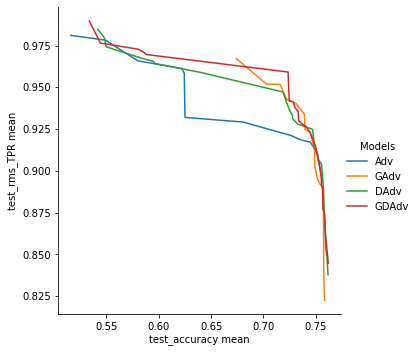

In [153]:
_results_dict = {
    "Adv": Moji_Adv_df,
    "GAdv": Moji_GatedAdv_df,
    "DAdv": Moji_DAdv_df,
    "GDAdv": Moji_GatedDAdv_df,
}

_final_df = model_comparasion(
    results_dict = _results_dict,
    pareto_selection="test",
    )

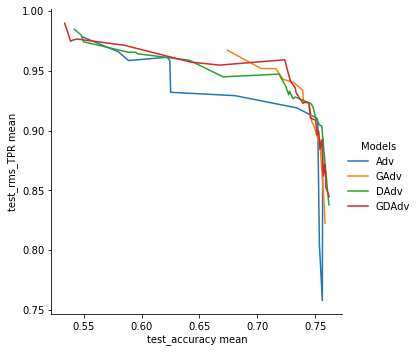

In [154]:
_results_dict = {
    "Adv": Moji_Adv_df,
    "GAdv": Moji_GatedAdv_df,
    "DAdv": Moji_DAdv_df,
    "GDAdv": Moji_GatedDAdv_df,
}

_final_df = model_comparasion(
    results_dict = _results_dict,
    pareto_selection="dev",
    )

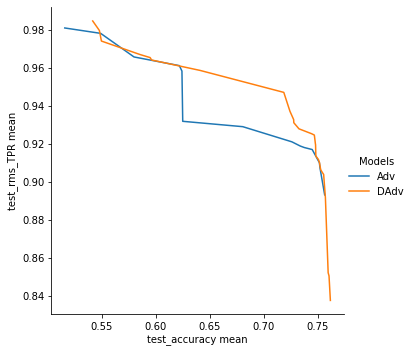

In [143]:
_results_dict = {
    "Adv": Moji_Adv_df,
    # "GAdv": Moji_GatedAdv_df,
    "DAdv": Moji_DAdv_df,
    # "GDAdv": Moji_GatedDAdv_df,
}

_final_df = model_comparasion(
    results_dict = _results_dict,
    pareto_selection="test"
    )

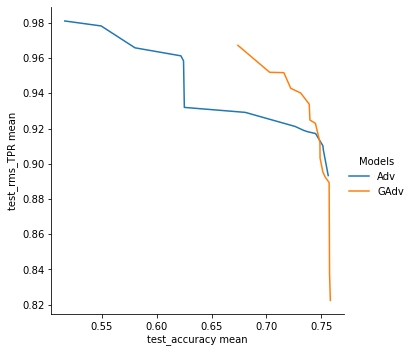

In [144]:
_results_dict = {
    "Adv": Moji_Adv_df,
    "GAdv": Moji_GatedAdv_df,
    # "DAdv": Moji_DAdv_df,
    # "GDAdv": Moji_GatedDAdv_df,
}

_final_df = model_comparasion(
    results_dict = _results_dict,
    pareto_selection="test"
    )

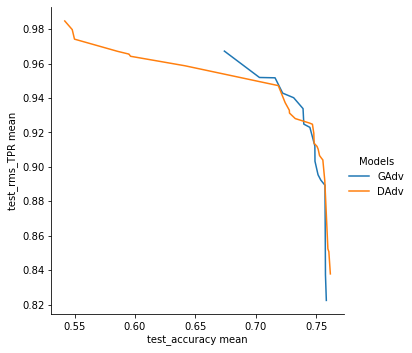

In [145]:
_results_dict = {
    # "Adv": Moji_Adv_df,
    "GAdv": Moji_GatedAdv_df,
    "DAdv": Moji_DAdv_df,
    # "GDAdv": Moji_GatedDAdv_df,
}

_final_df = model_comparasion(
    results_dict = _results_dict,
    pareto_selection="test"
    )

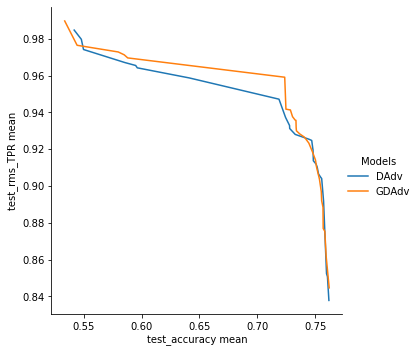

In [146]:
_results_dict = {
    # "Adv": Moji_Adv_df,
    # "GAdv": Moji_GatedAdv_df,
    "DAdv": Moji_DAdv_df,
    "GDAdv": Moji_GatedDAdv_df,
}

_final_df = model_comparasion(
    results_dict = _results_dict,
    pareto_selection="test"
    )

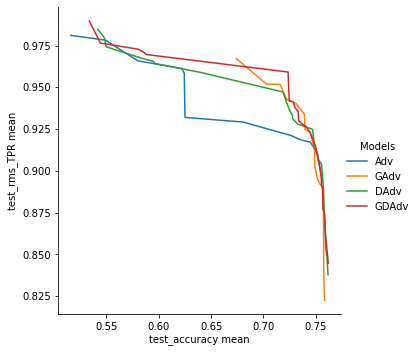

In [147]:
_results_dict = {
    "Adv": Moji_Adv_df,
    "GAdv": Moji_GatedAdv_df,
    "DAdv": Moji_DAdv_df,
    "GDAdv": Moji_GatedDAdv_df,
}

_final_df = model_comparasion(
    results_dict = _results_dict,
    pareto_selection="test"
    )

In [50]:
pareto_flag = is_pareto_efficient(
    costs=-1*Moji_GatedAdv_df[["dev_rms_TPR", "dev_accuracy"]].to_numpy()
)

In [51]:
Moji_GatedAdv_df[pareto_flag]

,adv_lambda,adv_num_subDiscriminator,adv_diverse_lambda,selected_epoch,dev_rms_TPR,dev_accuracy,dev_DTO,test_rms_TPR,test_accuracy,test_DTO
160,1.584893,1,0.0,7.0,0.827069,0.757000,0.000000,0.798272,0.762816,0.000000
180,1000.000000,1,0.0,1.0,0.994245,0.504375,0.120669,0.993827,0.502126,0.144754
185,12.589254,1,0.0,11.0,0.922849,0.751250,0.007923,0.910315,0.757939,0.013979
190,125.892541,1,0.0,33.0,0.957677,0.732250,0.049304,0.948554,0.737809,0.057533
191,125.892541,1,0.0,20.0,0.968915,0.717000,0.025029,0.945307,0.724306,0.030077
200,158.489319,1,0.0,26.0,0.983233,0.702125,0.034116,0.969149,0.701175,0.049092
203,158.489319,1,0.0,20.0,0.942041,0.743750,0.033910,0.924027,0.752313,0.034879
205,19.952623,1,0.0,5.0,0.943030,0.737875,0.027192,0.920662,0.741185,0.032045
220,25.118864,1,0.0,27.0,0.935438,0.748250,0.012374,0.918412,0.746812,0.023404
222,25.118864,1,0.0,12.0,0.955770,0.732500,0.030122,0.944483,0.739060,0.026756


In [25]:
Moji_GatedAdv_df

,adv_lambda,adv_num_subDiscriminator,adv_diverse_lambda,selected_epoch,dev_rms_TPR,dev_accuracy,dev_DTO,test_rms_TPR,test_accuracy,test_DTO
0,0.001259,1,0.0,11.0,0.631400,0.727000,0.000000,0.609150,0.725681,0.000000
1,0.001259,1,0.0,3.0,0.612591,0.725375,0.001707,0.597582,0.721430,0.002248
2,0.001259,1,0.0,8.0,0.621809,0.723875,0.001552,0.600195,0.722681,0.012172
3,0.001259,1,0.0,0.0,0.624953,0.727125,0.000435,0.604805,0.723931,0.003099
4,0.001259,1,0.0,0.0,0.621439,0.724375,0.001146,0.601644,0.723306,0.011045
...,...,...,...,...,...,...,...,...,...,...
300,794.328235,1,0.0,8.0,0.953249,0.519625,0.084368,0.954716,0.519630,0.107505
301,794.328235,1,0.0,14.0,0.973072,0.633875,0.029873,0.934700,0.638160,0.052829
302,794.328235,1,0.0,7.0,0.965064,0.641250,0.034534,0.953222,0.650413,0.034567
303,794.328235,1,0.0,5.0,0.983748,0.650375,0.023886,0.958095,0.651288,0.036114


In [96]:
df = model_selection(
    results_dir= r"..\results",
    project_dir= "dev",
    checkpoint_dir= "models",
    checkpoint_name= "checkpoint_epoch",
    model_id= "GB_Adv",
    GAP_metric_name = "rms_TPR",
    Performance_metric_name = "accuracy",
    selection_criterion = "DTO",
    )

100%|██████████| 4/4 [00:03<00:00,  1.10it/s]


In [97]:
df.keys()

Index(['adv_lambda', 'adv_num_subDiscriminator', 'adv_diverse_lambda',
       'selected_epoch', 'dev_rms_TPR', 'dev_accuracy', 'dev_DTO',
       'test_rms_TPR', 'test_accuracy', 'test_DTO'],
      dtype='object')

In [98]:
_df = df.set_index(['adv_lambda', 'adv_num_subDiscriminator', 'adv_diverse_lambda'])

In [99]:
__df = _df.groupby(_df.index).agg(["mean", "var"]).reset_index()
__df

index selected_epoch     dev_rms_TPR     dev_accuracy      \
                            mean var        mean var         mean var   
0   (0.5, 1, 0.0)            5.0 NaN    0.716165 NaN     0.743250 NaN   
1   (1.0, 1, 0.0)           11.0 NaN    0.825103 NaN     0.748750 NaN   
2   (5.0, 1, 0.0)           10.0 NaN    0.875480 NaN     0.688000 NaN   
3  (10.0, 1, 0.0)           10.0 NaN    0.938848 NaN     0.679375 NaN   

    dev_DTO     test_rms_TPR     test_accuracy      test_DTO      
       mean var         mean var          mean var      mean var  
0  0.021077 NaN     0.695574 NaN      0.744686 NaN  0.030387 NaN  
1  0.001500 NaN     0.795695 NaN      0.753563 NaN  0.000858 NaN  
2  0.079445 NaN     0.852941 NaN      0.687172 NaN  0.084458 NaN  
3  0.117103 NaN     0.923288 NaN      0.683421 NaN  0.129179 NaN

In [139]:
Moji_adv_df = model_selection(
    results_dir= r"G:\Experimental_results",
    project_dir= r"hypertune/Moji",
    checkpoint_dir= "models",
    checkpoint_name= "checkpoint_epoch",
    model_id= "hypertune_Adv",
    GAP_metric_name = "rms_TPR",
    Performance_metric_name = "accuracy",
    selection_criterion = "DTO",
    )

100%|██████████| 305/305 [05:02<00:00,  1.01it/s]


In [102]:
# Moji_adv_df
_df = Moji_adv_df.set_index(['adv_lambda', 'adv_num_subDiscriminator', 'adv_diverse_lambda'])

__df = _df.groupby(_df.index).agg(["mean", "var"]).reset_index()
__df

index selected_epoch        dev_rms_TPR  \
                                              mean    var        mean   
0                   (0.001, 1, 0.0)            6.6   32.3    0.624268   
1   (0.0012589254117941675, 1, 0.0)            9.0   21.5    0.624278   
2    (0.001584893192461114, 1, 0.0)            5.8   18.7    0.622711   
3    (0.001995262314968879, 1, 0.0)            7.8   28.7    0.626494   
4   (0.0025118864315095794, 1, 0.0)            6.0    8.0    0.625507   
..                              ...            ...    ...         ...   
56      (398.1071705534977, 1, 0.0)           16.2  502.2    0.945090   
57     (501.18723362727246, 1, 0.0)           14.0  394.0    0.958637   
58      (630.9573444801943, 1, 0.0)           18.0  621.5    0.957003   
59      (794.3282347242822, 1, 0.0)            7.6  252.3    0.967847   
60                 (1000.0, 1, 0.0)            1.0    3.0    0.979537   

             dev_accuracy                 dev_DTO               test_rms_TPR  \
         var         mean           var      mean           var         mean   
0   0.000094     0.725425  2.004688e-06  0.000345  5.935066e-07     0.605033   
1   0.000045     0.724400  1.671875e-07  0.001410  6.421182e-06     0.602397   
2   0.000024     0.726175  5.750000e-07  0.001153  2.517812e-06     0.602822   
3   0.000035     0.724275  4.417188e-06  0.002513  6.595423e-06     0.604025   
4   0.000037     0.724750  9.609375e-07  0.002030  2.492566e-06     0.605002   
..       ...          ...           ...       ...           ...          ...   
56  0.002672     0.615475  1.322925e-02  0.035698  2.429724e-03     0.938788   
57  0.002468     0.576800  1.110252e-02  0.124150  2.274507e-03     0.952053   
58  0.003473     0.583325  1.303042e-02  0.045628  2.873207e-03     0.958258   
59  0.002229     0.556100  6.741519e-03  0.030185  1.892899e-03     0.960635   
60  0.002094     0.515175  1.151403e-03  0.022995  2.643874e-03     0.981066   

             test_accuracy            test_DTO            
         var          mean       var      mean       var  
0   0.000098      0.723556  0.000002  0.001484  0.000001  
1   0.000034      0.722731  0.000008  0.002752  0.000012  
2   0.000023      0.723956  0.000005  0.007075  0.000089  
3   0.000015      0.719855  0.000012  0.007419  0.000057  
4   0.000047      0.723306  0.000011  0.002922  0.000012  
..       ...           ...       ...       ...       ...  
56  0.003266      0.619205  0.014014  0.040707  0.003135  
57  0.003502      0.579195  0.011758  0.125263  0.001943  
58  0.003345      0.586697  0.014109  0.045275  0.002649  
59  0.003391      0.559415  0.007539  0.030678  0.001809  
60  0.001792      0.515979  0.001277  0.021231  0.002254  

[61 rows x 15 columns]

In [105]:
import math

In [109]:
_log_lambda = [round(math.log10(i[0]), 2) for i in __df["index"]]
__df["log_lambda"] = _log_lambda

In [117]:
_final_DTO = DTO(fairness_metric=list(__df[("test_rms_TPR", "mean")]), performacne_metric=list(__df[("test_accuracy", "mean")]))
__df["final_DTO"] = _final_DTO

In [119]:
__df

index selected_epoch        dev_rms_TPR  \
                                              mean    var        mean   
0                   (0.001, 1, 0.0)            6.6   32.3    0.624268   
1   (0.0012589254117941675, 1, 0.0)            9.0   21.5    0.624278   
2    (0.001584893192461114, 1, 0.0)            5.8   18.7    0.622711   
3    (0.001995262314968879, 1, 0.0)            7.8   28.7    0.626494   
4   (0.0025118864315095794, 1, 0.0)            6.0    8.0    0.625507   
..                              ...            ...    ...         ...   
56      (398.1071705534977, 1, 0.0)           16.2  502.2    0.945090   
57     (501.18723362727246, 1, 0.0)           14.0  394.0    0.958637   
58      (630.9573444801943, 1, 0.0)           18.0  621.5    0.957003   
59      (794.3282347242822, 1, 0.0)            7.6  252.3    0.967847   
60                 (1000.0, 1, 0.0)            1.0    3.0    0.979537   

             dev_accuracy                 dev_DTO               test_rms_TPR  \
         var         mean           var      mean           var         mean   
0   0.000094     0.725425  2.004688e-06  0.000345  5.935066e-07     0.605033   
1   0.000045     0.724400  1.671875e-07  0.001410  6.421182e-06     0.602397   
2   0.000024     0.726175  5.750000e-07  0.001153  2.517812e-06     0.602822   
3   0.000035     0.724275  4.417188e-06  0.002513  6.595423e-06     0.604025   
4   0.000037     0.724750  9.609375e-07  0.002030  2.492566e-06     0.605002   
..       ...          ...           ...       ...           ...          ...   
56  0.002672     0.615475  1.322925e-02  0.035698  2.429724e-03     0.938788   
57  0.002468     0.576800  1.110252e-02  0.124150  2.274507e-03     0.952053   
58  0.003473     0.583325  1.303042e-02  0.045628  2.873207e-03     0.958258   
59  0.002229     0.556100  6.741519e-03  0.030185  1.892899e-03     0.960635   
60  0.002094     0.515175  1.151403e-03  0.022995  2.643874e-03     0.981066   

             test_accuracy            test_DTO           log_lambda final_DTO  
         var          mean       var      mean       var                       
0   0.000098      0.723556  0.000002  0.001484  0.000001       -3.0  0.385744  
1   0.000034      0.722731  0.000008  0.002752  0.000012       -2.9  0.388538  
2   0.000023      0.723956  0.000005  0.007075  0.000089       -2.8  0.387925  
3   0.000015      0.719855  0.000012  0.007419  0.000057       -2.7  0.387345  
4   0.000047      0.723306  0.000011  0.002922  0.000012       -2.6  0.385813  
..       ...           ...       ...       ...       ...        ...       ...  
56  0.003266      0.619205  0.014014  0.040707  0.003135        2.6  0.186443  
57  0.003502      0.579195  0.011758  0.125263  0.001943        2.7  0.236148  
58  0.003345      0.586697  0.014109  0.045275  0.002649        2.8  0.225572  
59  0.003391      0.559415  0.007539  0.030678  0.001809        2.9  0.261270  
60  0.001792      0.515979  0.001277  0.021231  0.002254        3.0  0.317862  

[61 rows x 17 columns]

In [112]:
import seaborn as sns

C:\Users\emano\.conda\envs\py37\lib\site-packages\seaborn\relational.py:1068: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  right_index=True,


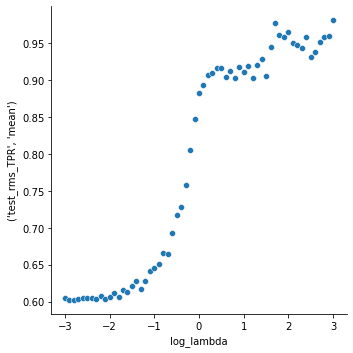

In [115]:
sns.relplot(data=__df, x="log_lambda", y=("test_rms_TPR", "mean"))

C:\Users\emano\.conda\envs\py37\lib\site-packages\seaborn\relational.py:1068: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  right_index=True,


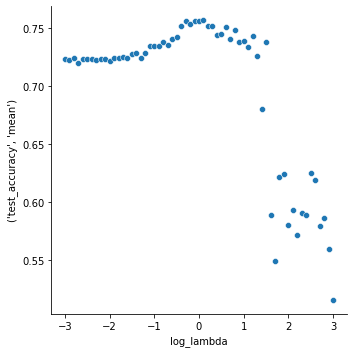

In [116]:
sns.relplot(data=__df, x="log_lambda", y=("test_accuracy", "mean"))

C:\Users\emano\.conda\envs\py37\lib\site-packages\seaborn\relational.py:1068: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  right_index=True,


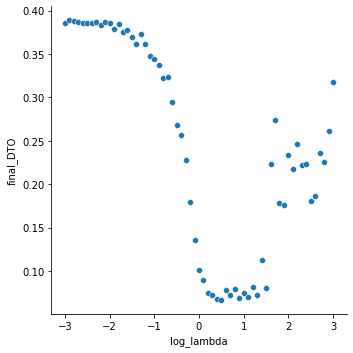

In [120]:
sns.relplot(data=__df, x="log_lambda", y="final_DTO")

C:\Users\emano\.conda\envs\py37\lib\site-packages\seaborn\relational.py:1068: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  right_index=True,


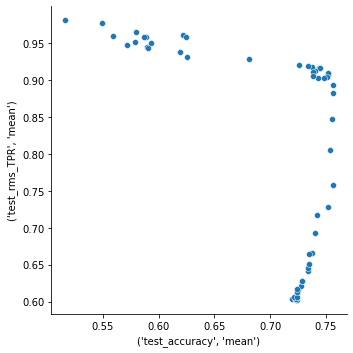

In [121]:
sns.relplot(data=__df, x=("test_accuracy", "mean"), y=("test_rms_TPR", "mean"))

In [122]:
Moji_DAdv_df = model_selection(
    results_dir= r"G:\Experimental_results",
    project_dir= "hypertune",
    checkpoint_dir= "models",
    checkpoint_name= "checkpoint_epoch",
    model_id= "hypertune_DAdv",
    GAP_metric_name = "rms_TPR",
    Performance_metric_name = "accuracy",
    selection_criterion = "DTO",
    )

100%|██████████| 1525/1525 [28:21<00:00,  1.12s/it]


In [123]:
Moji_DAdv_df

,adv_lambda,adv_num_subDiscriminator,adv_diverse_lambda,selected_epoch,dev_rms_TPR,dev_accuracy,dev_DTO,test_rms_TPR,test_accuracy,test_DTO
0,0.001259,3,0.01,4.0,0.629098,0.726750,0.000000,0.613403,0.725681,0.001376
1,0.001259,3,0.01,6.0,0.632588,0.728375,0.002858,0.614998,0.728057,0.000000
2,0.001259,3,0.01,2.0,0.621740,0.726750,0.000000,0.604392,0.722056,0.000000
3,0.001259,3,0.01,14.0,0.622550,0.721625,0.001557,0.598692,0.719805,0.022004
4,0.001259,3,0.01,10.0,0.634467,0.725625,0.000549,0.617448,0.724806,0.001406
...,...,...,...,...,...,...,...,...,...,...
1520,794.328235,3,100.00,25.0,0.900438,0.611500,0.130860,0.909948,0.614904,0.128941
1521,794.328235,3,100.00,28.0,0.915129,0.686375,0.099008,0.917973,0.688422,0.097824
1522,794.328235,3,100.00,0.0,1.000000,0.500000,0.000000,1.000000,0.500000,0.000000
1523,794.328235,3,100.00,1.0,1.000000,0.500000,0.000250,1.000000,0.500000,0.000500


In [130]:
def create_plots(input_df, index_column_names = ['adv_lambda', 'adv_num_subDiscriminator', 'adv_diverse_lambda']):
    # Moji_adv_df
    _df = input_df.set_index(index_column_names)

    __df = _df.groupby(_df.index).agg(["mean", "var"]).reset_index()
    __df

    _log_lambda = [round(math.log10(i[0]), 2) for i in __df["index"]]
    __df["log_lambda"] = _log_lambda

    _final_DTO = DTO(fairness_metric=list(__df[("test_rms_TPR", "mean")]), performacne_metric=list(__df[("test_accuracy", "mean")]))
    __df["final_DTO"] = _final_DTO

    sns.relplot(data=__df, x="log_lambda", y="final_DTO")

    sns.relplot(data=__df, x=("test_accuracy", "mean"), y=("test_rms_TPR", "mean"))

    return __df[__df["final_DTO"] == min(_final_DTO)]

C:\Users\emano\.conda\envs\py37\lib\site-packages\seaborn\relational.py:1068: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  right_index=True,
C:\Users\emano\.conda\envs\py37\lib\site-packages\seaborn\relational.py:1068: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  right_index=True,


index selected_epoch       dev_rms_TPR            \
                                           mean   var        mean       var   
35  (3.1622776601683795, 1, 0.0)            7.0  11.0    0.918121  0.000111   

   dev_accuracy             dev_DTO           test_rms_TPR            \
           mean       var      mean       var         mean       var   
35     0.736425  0.000185  0.037474  0.000943     0.917136  0.000322   

   test_accuracy           test_DTO           log_lambda final_DTO  
            mean      var      mean       var                       
35      0.744886  0.00019  0.038799  0.000925        0.5  0.066922

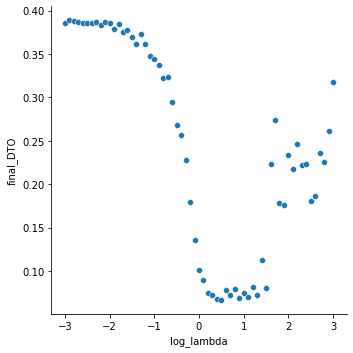

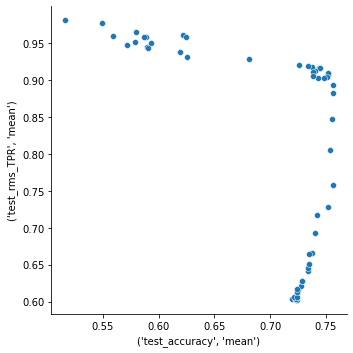

In [132]:
create_plots(input_df = Moji_adv_df)

C:\Users\emano\.conda\envs\py37\lib\site-packages\seaborn\relational.py:1068: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  right_index=True,
C:\Users\emano\.conda\envs\py37\lib\site-packages\seaborn\relational.py:1068: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  right_index=True,


index selected_epoch       dev_rms_TPR  \
                                              mean   var        mean   
179  (3.1622776601683795, 3, 100.0)           12.0  35.5    0.925327   

              dev_accuracy             dev_DTO          test_rms_TPR  \
          var         mean       var      mean      var         mean   
179  0.000212      0.73735  0.000066  0.023413  0.00009      0.92475   

              test_accuracy            test_DTO           log_lambda final_DTO  
          var          mean       var      mean       var                       
179  0.000468      0.746862  0.000052  0.029076  0.000206        0.5  0.063965

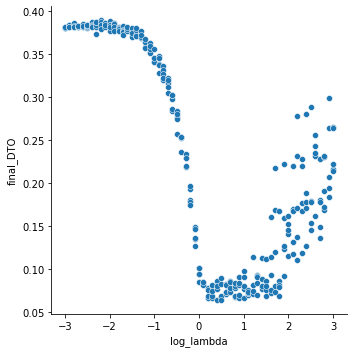

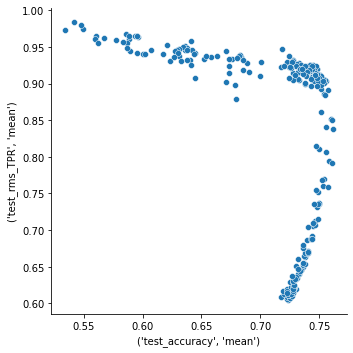

In [137]:
create_plots(input_df = Moji_DAdv_df)

C:\Users\emano\.conda\envs\py37\lib\site-packages\seaborn\relational.py:1068: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  right_index=True,
C:\Users\emano\.conda\envs\py37\lib\site-packages\seaborn\relational.py:1068: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  right_index=True,


index selected_epoch       dev_rms_TPR            \
                                           mean   var        mean       var   
39  (7.943282347242821, 3, 0.01)           14.6  74.3    0.924792  0.000192   

   dev_accuracy             dev_DTO           test_rms_TPR            \
           mean       var      mean       var         mean       var   
39     0.735375  0.000103  0.036989  0.000578     0.925248  0.000138   

   test_accuracy            test_DTO           log_lambda final_DTO  
            mean       var      mean       var                       
39      0.742061  0.000096  0.038914  0.000778        0.9  0.054025

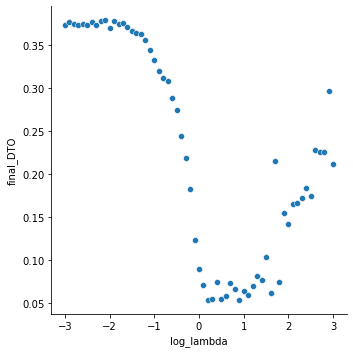

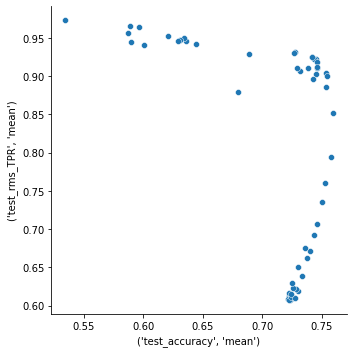

In [131]:
create_plots(input_df = Moji_DAdv_df[Moji_DAdv_df["adv_diverse_lambda"]==0.01])

C:\Users\emano\.conda\envs\py37\lib\site-packages\seaborn\relational.py:1068: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  right_index=True,
C:\Users\emano\.conda\envs\py37\lib\site-packages\seaborn\relational.py:1068: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  right_index=True,


index selected_epoch       dev_rms_TPR            \
                                          mean   var        mean       var   
38  (6.309573444801936, 3, 0.1)           12.2  23.7    0.923504  0.000227   

   dev_accuracy             dev_DTO           test_rms_TPR            \
           mean       var      mean       var         mean       var   
38     0.734325  0.000214  0.044523  0.001028     0.923851  0.000253   

   test_accuracy            test_DTO          log_lambda final_DTO  
            mean       var      mean      var                       
38      0.740585  0.000263  0.046709  0.00097        0.8  0.067331

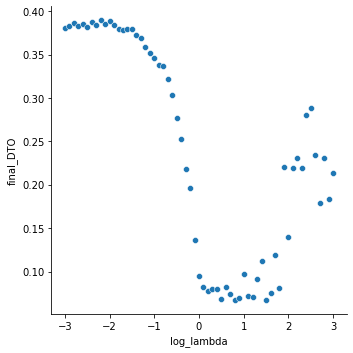

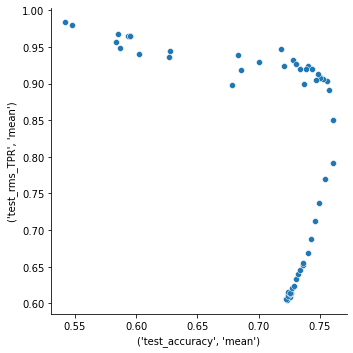

In [133]:
create_plots(input_df = Moji_DAdv_df[Moji_DAdv_df["adv_diverse_lambda"]==0.1])

C:\Users\emano\.conda\envs\py37\lib\site-packages\seaborn\relational.py:1068: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  right_index=True,
C:\Users\emano\.conda\envs\py37\lib\site-packages\seaborn\relational.py:1068: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  right_index=True,


index selected_epoch       dev_rms_TPR            \
                                          mean   var        mean       var   
32  (1.584893192461114, 3, 1.0)            8.2  15.7    0.924432  0.000305   

   dev_accuracy             dev_DTO           test_rms_TPR            \
           mean       var      mean       var         mean       var   
32     0.738075  0.000119  0.023187  0.000247     0.922809  0.000483   

   test_accuracy           test_DTO           log_lambda final_DTO  
            mean      var      mean       var                       
32      0.745961  0.00012  0.027834  0.000195        0.2  0.054209

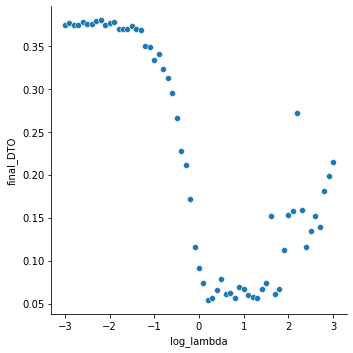

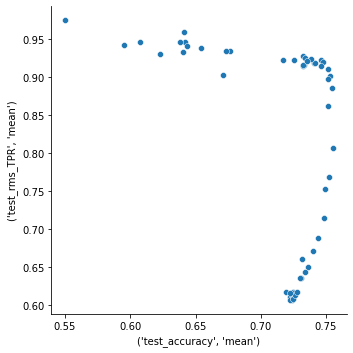

In [134]:
create_plots(input_df = Moji_DAdv_df[Moji_DAdv_df["adv_diverse_lambda"]==1])

index selected_epoch        dev_rms_TPR           dev_accuracy  \
                              mean    var        mean       var         mean   
40  (10.0, 3, 10.0)           19.0  164.0    0.925851  0.000099     0.736125   

               dev_DTO           test_rms_TPR           test_accuracy  \
         var      mean       var         mean       var          mean   
40  0.000029  0.051583  0.000774     0.923584  0.000127      0.744211   

              test_DTO           log_lambda final_DTO  
         var      mean       var                       
40  0.000008  0.052879  0.000406        1.0  0.045389

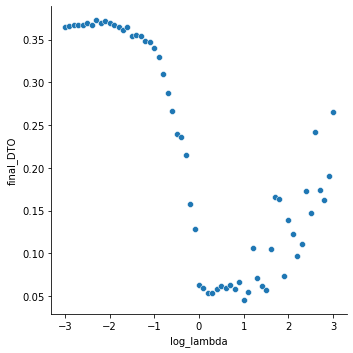

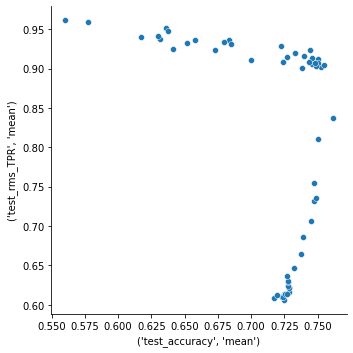

In [138]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

create_plots(input_df = Moji_DAdv_df[Moji_DAdv_df["adv_diverse_lambda"]==10])

C:\Users\emano\.conda\envs\py37\lib\site-packages\seaborn\relational.py:1068: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  right_index=True,
C:\Users\emano\.conda\envs\py37\lib\site-packages\seaborn\relational.py:1068: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  right_index=True,


index selected_epoch       dev_rms_TPR            \
                                             mean   var        mean       var   
35  (3.1622776601683795, 3, 100.0)           12.0  35.5    0.925327  0.000212   

   dev_accuracy             dev_DTO          test_rms_TPR            \
           mean       var      mean      var         mean       var   
35      0.73735  0.000066  0.023413  0.00009      0.92475  0.000468   

   test_accuracy            test_DTO           log_lambda final_DTO  
            mean       var      mean       var                       
35      0.746862  0.000052  0.029076  0.000206        0.5  0.044464

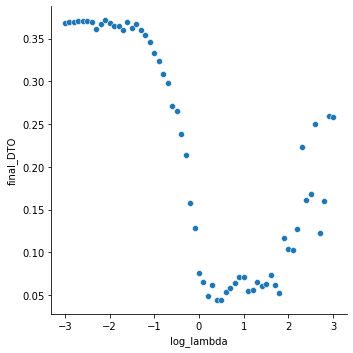

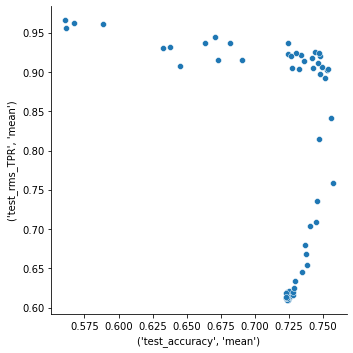

In [136]:
create_plots(input_df = Moji_DAdv_df[Moji_DAdv_df["adv_diverse_lambda"]==100])